In [ ]:
# Artigo de referência: Time-Series Forecasting of Crude Oil Production Using Hybrid Modeling

In [ ]:
!pip install feature-engine
!pip install neuralforecast

In [71]:
import pandas as pd
from time import time
from neuralforecast import NeuralForecast
from neuralforecast.models import NLinear
from neuralforecast.losses.pytorch import MQLoss
from matplotlib import pyplot as plt

In [70]:
ROOT = "/content/drive/MyDrive/dl-project"
DATA_FILE = f"{ROOT}/data/01-univariate/Florida_Field_Production_of_Crude_Oil.csv"

SEED = 78

training_proportion = 0.90
horizon = 12
input_size = horizon * 2

time_spent = {}

In [58]:
data = pd.read_csv(DATA_FILE)

In [59]:
rename_columns = {
    "Month": "ds",
    "Florida Field Production of Crude Oil Thousand Barrels per Day": "y"
}

data = (
    data
    .rename(columns=rename_columns)
    .assign(ds=lambda df_: pd.to_datetime(df_['ds'], format='%b %Y'))
    .sort_values(by="ds", ascending=True)
    .assign(unique_id="crude_oil_production")
)
data['unique_id'] = 'crude_oil_production'

In [60]:
data

,ds,y,unique_id
530,1981-01-01,116,crude_oil_production
529,1981-02-01,113,crude_oil_production
528,1981-03-01,102,crude_oil_production
527,1981-04-01,102,crude_oil_production
526,1981-05-01,98,crude_oil_production
...,...,...,...
4,2024-11-01,2,crude_oil_production
3,2024-12-01,2,crude_oil_production
2,2025-01-01,2,crude_oil_production
1,2025-02-01,2,crude_oil_production


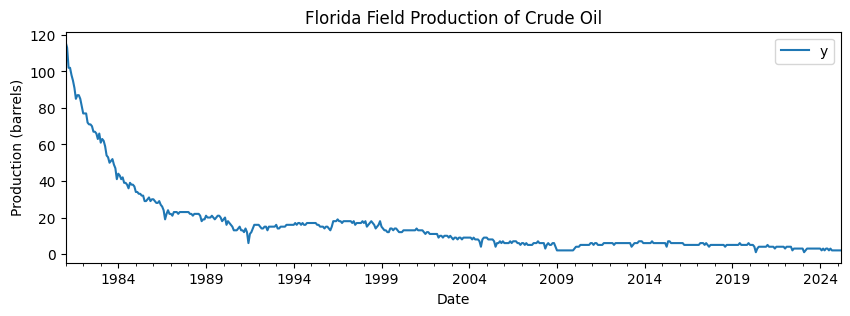

In [61]:
data.plot(
    x="ds",
    y="y",
    title="Florida Field Production of Crude Oil",
    figsize=(10, 3),
    xlabel="Date",
    ylabel="Production (barrels)"
);

In [62]:
split_point = int(len(data) * training_proportion)
train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]

In [63]:
train_data.shape, test_data.shape

((477, 3), (54, 3))

In [64]:
# Treinar NLinear com intervalos de predição
models = [
    NLinear(
        h=horizon,
        input_size=input_size,
        loss=MQLoss(quantiles=[0.05, 0.5, 0.95]),
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=5,
        random_seed=SEED
    )
]

INFO:lightning_fabric.utilities.seed:Seed set to 78


In [65]:
nf = NeuralForecast(
    models=models,
    freq='M'
)

In [74]:
start_time = time()
nf.fit(
    df=train_data, val_size=horizon
)
time_spent["training_time-NLinear"] = time() - start_time

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 3      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | linear       | Linear        | 900    | train
-------------------------------------------------------
900       Trainable params
3         Non-trainable params
903       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


In [78]:
print("NLinear training time:", round(time_spent["training_time-NLinear"], 1), "seconds")

NLinear training time: 24.9 seconds


In [79]:
# Junta os últimos 'input_size' pontos do treino com os dados de teste
predictions_input_df = pd.concat([train_data.tail(input_size), test_data])

In [81]:
# Cria janelas deslizantes do DataFrame para fazer predições
inputs_for_predicions_list = [
    predictions_input_df.iloc[i:i + input_size]
    for i in range(0, len(predictions_input_df) - input_size + 1, horizon)
]

In [ ]:
forecasts_list = []
start_time = time()

for input_df in inputs_for_predicions_list:
    forecast = nf.predict(df=input_df)
    forecasts_list.append(forecast)

time_spent["inference_time-NLinear"] = time() - start_time

In [88]:
print("NLinear inference time:", round(time_spent["inference_time-NLinear"], 1), "seconds")

NLinear inference time: 0.9 seconds


In [96]:
forecasts_output = (
    pd.concat(forecasts_list)
    .rename(
        columns={
            "NLinear-lo-90.0": "y_lower",
            "NLinear-median": "y_pred",
            "NLinear-hi-90.0": "y_upper"
        }
    )
    .assign(ds=lambda df_: df_['ds'] + pd.offsets.MonthBegin(0))
)
forecasts_output

,unique_id,ds,y_lower,y_pred,y_upper
0,crude_oil_production,2020-10-01,3.650922,3.955357,4.195556
1,crude_oil_production,2020-11-01,3.384712,3.616866,3.981434
2,crude_oil_production,2020-12-01,4.107571,3.436563,4.128992
3,crude_oil_production,2021-01-01,4.050323,4.580504,5.060187
4,crude_oil_production,2021-02-01,3.963958,4.279160,3.392756
5,crude_oil_production,2021-03-01,3.687940,2.841357,4.357235
6,crude_oil_production,2021-04-01,3.566087,3.472565,4.330591
7,crude_oil_production,2021-05-01,3.709094,3.261465,4.353595
8,crude_oil_production,2021-06-01,3.967975,3.523371,4.636668
9,crude_oil_production,2021-07-01,4.077711,2.762984,4.573483


In [97]:
ground_truth = test_data.copy()
ground_truth

,ds,y,unique_id
53,2020-10-01,4,crude_oil_production
52,2020-11-01,4,crude_oil_production
51,2020-12-01,4,crude_oil_production
50,2021-01-01,5,crude_oil_production
49,2021-02-01,4,crude_oil_production
48,2021-03-01,4,crude_oil_production
47,2021-04-01,4,crude_oil_production
46,2021-05-01,4,crude_oil_production
45,2021-06-01,3,crude_oil_production
44,2021-07-01,4,crude_oil_production


In [98]:
nlinear_results = pd.merge(
    ground_truth,
    forecasts_output,
    on=['unique_id', 'ds'],
    how='inner'
)
nlinear_results

,ds,y,unique_id,y_lower,y_pred,y_upper
0,2020-10-01,4,crude_oil_production,3.650922,3.955357,4.195556
1,2020-11-01,4,crude_oil_production,3.384712,3.616866,3.981434
2,2020-12-01,4,crude_oil_production,4.107571,3.436563,4.128992
3,2021-01-01,5,crude_oil_production,4.050323,4.580504,5.060187
4,2021-02-01,4,crude_oil_production,3.963958,4.279160,3.392756
5,2021-03-01,4,crude_oil_production,3.687940,2.841357,4.357235
6,2021-04-01,4,crude_oil_production,3.566087,3.472565,4.330591
7,2021-05-01,4,crude_oil_production,3.709094,3.261465,4.353595
8,2021-06-01,3,crude_oil_production,3.967975,3.523371,4.636668
9,2021-07-01,4,crude_oil_production,4.077711,2.762984,4.573483


In [100]:
# Salvar Resultados
nlinear_results.to_csv(f"{ROOT}/results/03-multivariate/nlinear_results.csv", index=False)

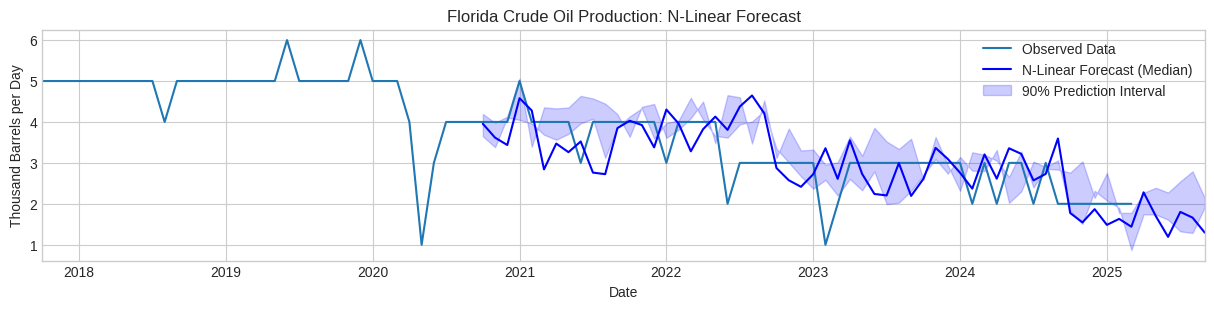

In [105]:
# Plotar a previsão com intervalos de predição
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 3))

# Plotar dados históricos (últimos 3x passos do horizonte para contexto)
plot_df = pd.concat([train_data.tail(3 * horizon), test_data]).set_index('ds')
plot_df['y'].plot(ax=ax, label='Observed Data')

# Plotar a previsão
forecasts_plot = forecasts_output.set_index('ds')
forecasts_plot['y_pred'].plot(ax=ax, label='N-Linear Forecast (Median)', color='blue')

# Sombrear o intervalo de predição
ax.fill_between(
   forecasts_plot.index,
   forecasts_plot['y_lower'],
   forecasts_plot['y_upper'],
   color='blue',
   alpha=0.2,
   label='90% Prediction Interval'
)

ax.set_title('Florida Crude Oil Production: N-Linear Forecast')
ax.set_ylabel('Thousand Barrels per Day')
ax.set_xlabel('Date')
ax.legend(loc='upper right')
ax.grid(True)
plt.show()